#### Importing Libraries needed

In [6]:
# for handling dataframes
import pandas as pd
# data frame calculations
import numpy as np
#plotting, visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Linear Regressiona and VIF
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

### 1. Problem
_Property valuation model is performing significantly lower in Henderson County (FIPS Code: 48213) county in Texas._

### 1.1 . County Model Performance Overview  

In [7]:
# readind the model performance data file
sum_data = pd.read_csv('county_model_performance.csv')

In [53]:
sum_data.columns

Index(['countyFIPS', 'countyName', 'nObservations', 'absError'], dtype='object')

In [52]:
sum_data.sort_values('absError', ascending=False)

,countyFIPS,countyName,nObservations,absError
7,48213,Henderson,7409,0.492501
14,48387,Red River,470,0.296028
6,48203,Harrison,4389,0.079365
13,48379,Rains,616,0.077776
4,48119,Delta,215,0.070554
0,48001,Anderson,2079,0.057498
17,48499,Wood,2076,0.051957
3,48073,Cherokee,2342,0.051451
1,48063,Camp,540,0.039266
2,48067,Cass,1791,0.038447


In [9]:
print('Total No of observations. All Counties: ', sum(sum_data.nObservations))

Total No of observations. All Counties:  36377


In [10]:
henderson_mask = sum_data.countyName == 'Henderson'
print('Total No of observations, Henderson County: ',sum_data[henderson_mask].nObservations.values[0])

Total No of observations, Henderson County:  7409


In [11]:
print('Abs Error, Henderson County: ', round(sum_data[henderson_mask].absError.values[0], 3))

Abs Error, Henderson County:  0.493


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


IndexError: index 0 is out of bounds for axis 0 with size 0

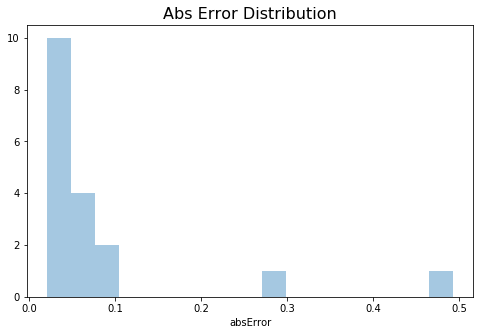

In [54]:
plt.figure(figsize = (8, 5))
ax = sns.distplot(sum_data.absError, kde = False, bins = 17)
plt.title('Abs Error Distribution', fontsize = 16)
plt.axvline(x = round(sum_data[henderson].absError.values[0], 3) , 
            c = 'c', label = 'Henderson County', linestyle = '--')
plt.legend()
plt.xticks(( 0.05, 0.1, 0.2, 0.3, 0.4, round(sum_data[henderson].absError.values[0], 2)), fontsize = 14, rotation = 0)
plt.ylabel('No of Counties', fontsize = 14)
plt.xlabel('Abs Error', fontsize = 14)

### 2.1 EDA. All Counties  

In [14]:
data = pd.read_csv('home_values_texas.csv')

In [15]:
data.sample(5)

,id,address,city,county,countyFIPS,state,zipcode,latitude,longitude,bedrooms,...,yearBuilt,taxYear,taxAssessedValue,taxMarketValue,taxImprovementValue,lastSaleDate,lastSaleAmount,priorSaleDate,priorSaleAmount,estimatedValue
204468,236197344,NaN,JACKSONVILLE,Cherokee,48073,TX,75766.0,NaN,NaN,0,...,1859.0,2018,110670.0,110670.0,89400.0,1979-06-28,NaN,NaN,NaN,147838
74027,215152715,1174 COUNTY ROAD 1660,ALBA,Wood,48499,TX,75410.0,32.758378,-95.613492,0,...,1980.0,2018,48760.0,48760.0,36080.0,2015-06-17,NaN,NaN,NaN,73000
99315,218153430,1401 BONHAM ST,PARIS,Lamar,48277,TX,75460.0,33.660458,-95.571199,0,...,NaN,2018,15778.0,32320.0,25760.0,2012-12-18,NaN,NaN,NaN,49871
187138,211480024,117 DOGWOOD LAKES CIR,BULLARD,Cherokee,48073,TX,75757.0,32.121243,-95.446092,0,...,NaN,2018,375100.0,375100.0,313060.0,2007-12-31,NaN,2003-06-19,NaN,415128
25455,235709644,195 ACR 2405,NaN,Anderson,48001,TX,NaN,31.863820,-95.773550,0,...,1981.0,2017,65419.0,65419.0,59419.0,NaN,NaN,NaN,NaN,93508


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234216 entries, 0 to 234215
Data columns (total 24 columns):
id                     234216 non-null int64
address                232332 non-null object
city                   231058 non-null object
county                 234216 non-null object
countyFIPS             234216 non-null int64
state                  234216 non-null object
zipcode                231048 non-null float64
latitude               180105 non-null float64
longitude              180105 non-null float64
bedrooms               234216 non-null int64
bathrooms              234216 non-null float64
rooms                  234216 non-null int64
squareFootage          186153 non-null float64
lotSize                169782 non-null float64
yearBuilt              155194 non-null float64
taxYear                234216 non-null int64
taxAssessedValue       227315 non-null float64
taxMarketValue         234101 non-null float64
taxImprovementValue    183635 non-null float64
lastSaleDa

In [55]:
data.columns

Index(['id', 'address', 'city', 'county', 'countyFIPS', 'state', 'zipcode',
       'latitude', 'longitude', 'bedrooms', 'bathrooms', 'rooms',
       'squareFootage', 'lotSize', 'yearBuilt', 'taxYear', 'taxAssessedValue',
       'taxMarketValue', 'taxImprovementValue', 'lastSaleDate',
       'lastSaleAmount', 'priorSaleDate', 'priorSaleAmount', 'estimatedValue'],
      dtype='object')

In [57]:
len(data), len(data.columns)

(234216, 24)

In [17]:
# looking at the descriptive statistics
data.describe()

,id,countyFIPS,zipcode,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,taxYear,taxAssessedValue,taxMarketValue,taxImprovementValue,lastSaleAmount,priorSaleAmount,estimatedValue
count,2.342160e+05,234216.000000,231048.000000,180105.000000,180105.000000,234216.000000,234216.000000,234216.000000,186153.000000,1.697820e+05,155194.000000,234216.000000,2.273150e+05,2.341010e+05,1.836350e+05,4.611100e+04,1.035600e+04,2.342160e+05
mean,2.125971e+08,48249.237038,75527.023519,32.694949,-95.278167,0.008471,0.404503,0.000111,1827.948908,1.625837e+05,1978.328666,2017.946566,8.277702e+04,8.711265e+04,8.203594e+04,5.110788e+03,1.265007e+04,1.472669e+05
std,4.613408e+07,167.111595,261.722753,0.561885,0.581150,0.164205,1.238846,0.018938,1668.752982,8.299344e+05,24.297818,0.244315,1.096361e+05,1.135075e+05,9.249787e+04,1.181843e+05,1.587536e+05,1.103765e+05
min,2.511470e+05,5119.000000,14050.000000,27.592073,-102.281259,0.000000,0.000000,0.000000,1.000000,4.400000e+01,1801.000000,2015.000000,1.000000e+01,1.000000e+01,1.000000e+01,0.000000e+00,0.000000e+00,5.000000e+01
25%,2.103059e+08,48203.000000,75436.000000,32.243110,-95.649273,0.000000,0.000000,0.000000,1168.000000,1.249700e+04,1964.000000,2018.000000,1.800000e+04,1.918000e+04,2.817000e+04,0.000000e+00,0.000000e+00,7.997900e+04
50%,2.170138e+08,48213.000000,75558.000000,32.669041,-95.446495,0.000000,0.000000,0.000000,1560.000000,3.088400e+04,1981.000000,2018.000000,5.496000e+04,5.759000e+04,5.936000e+04,0.000000e+00,0.000000e+00,1.213260e+05
75%,2.344737e+08,48365.000000,75752.000000,33.125765,-94.942037,0.000000,0.000000,0.000000,2108.000000,8.712000e+04,1997.000000,2018.000000,1.100600e+05,1.159000e+05,1.079700e+05,0.000000e+00,0.000000e+00,1.839612e+05
max,3.263044e+08,48499.000000,78227.000000,40.785734,-74.004371,7.000000,40.000000,5.000000,132590.000000,1.047380e+08,2018.000000,2018.000000,7.002000e+06,7.002000e+06,6.807461e+06,1.780000e+07,1.532135e+07,5.466093e+06


In [18]:
# looking at the shape of the dataset
data.shape

(234216, 24)

Text(0.5, 1.0, 'Null Values \n All Counties')

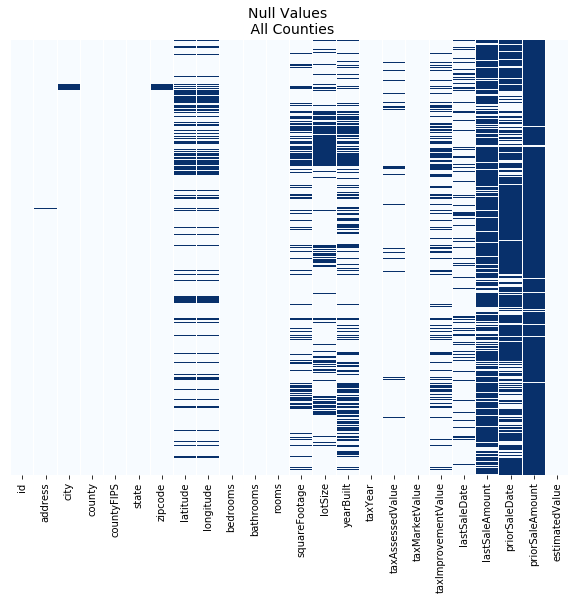

In [19]:
# Assessing Null Values
plt.figure(figsize = (10, 8))
sns.heatmap(data.isnull(), yticklabels = False, cbar = False, cmap = 'Blues')
plt.title('Null Values \n All Counties', fontsize = 14)


Text(0.5, 1.0, 'Feature Correlations \n All Counties')

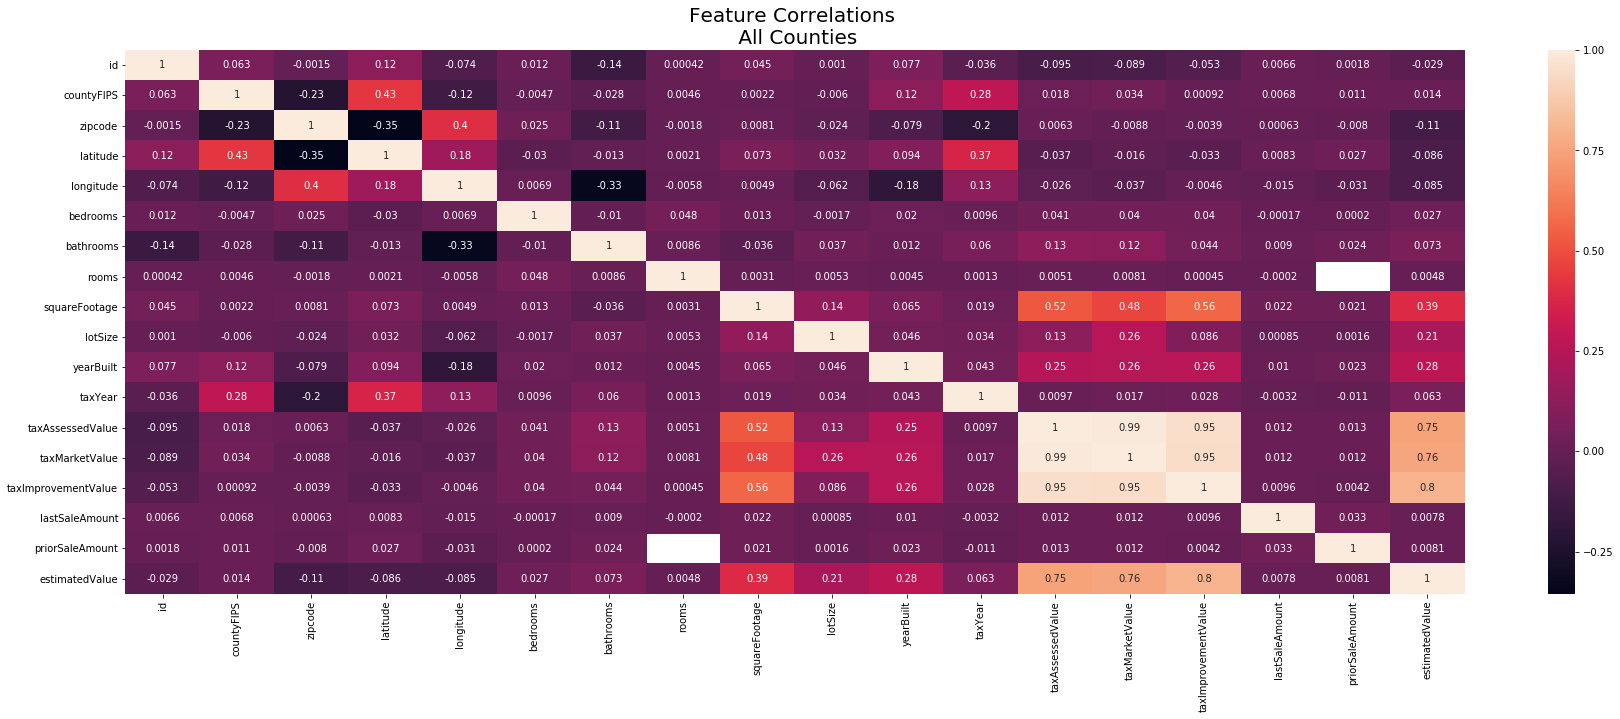

In [20]:
# feature correlation matrix
plt.figure(figsize = (30, 10))
sns.heatmap(data.corr(), annot = True)
plt.title('Feature Correlations \n All Counties', fontsize = 20)

* We see that our strongest predictors are **'taxAssessedValue','taxMarketValue', 'taxImprovementValue'** . All have high (>0.75) positive corr with the target. AS well as tax related features are highly correlated with each other.  
* SquareFootage is also positively correlated with the tax related features

(0, 1000000)

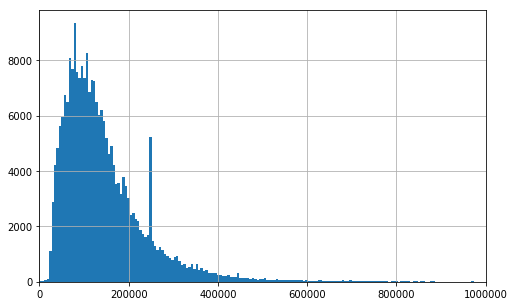

In [28]:
# Looking into target distribution
data.estimatedValue.hist(bins = 1000, figsize = (8, 5))
plt.xlim(0,1000000)

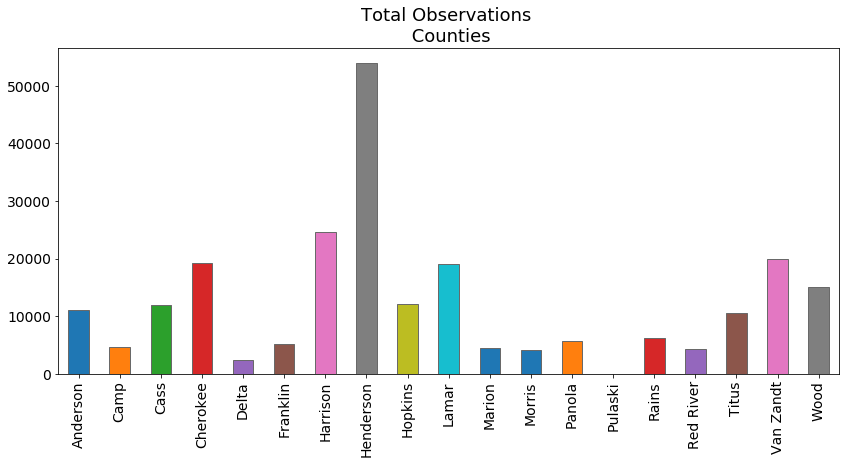

In [29]:
plt.title('Total Observations \n Counties', fontsize = 18)

plt.grid(c = 'lemonchiffon', linestyle = '--')
ax = data['county'].value_counts().sort_index().plot.bar(
    figsize = (14,6),
    fontsize = 14, edgecolor='dimgrey')

Text(0.5, 0, 'Estimated Value')

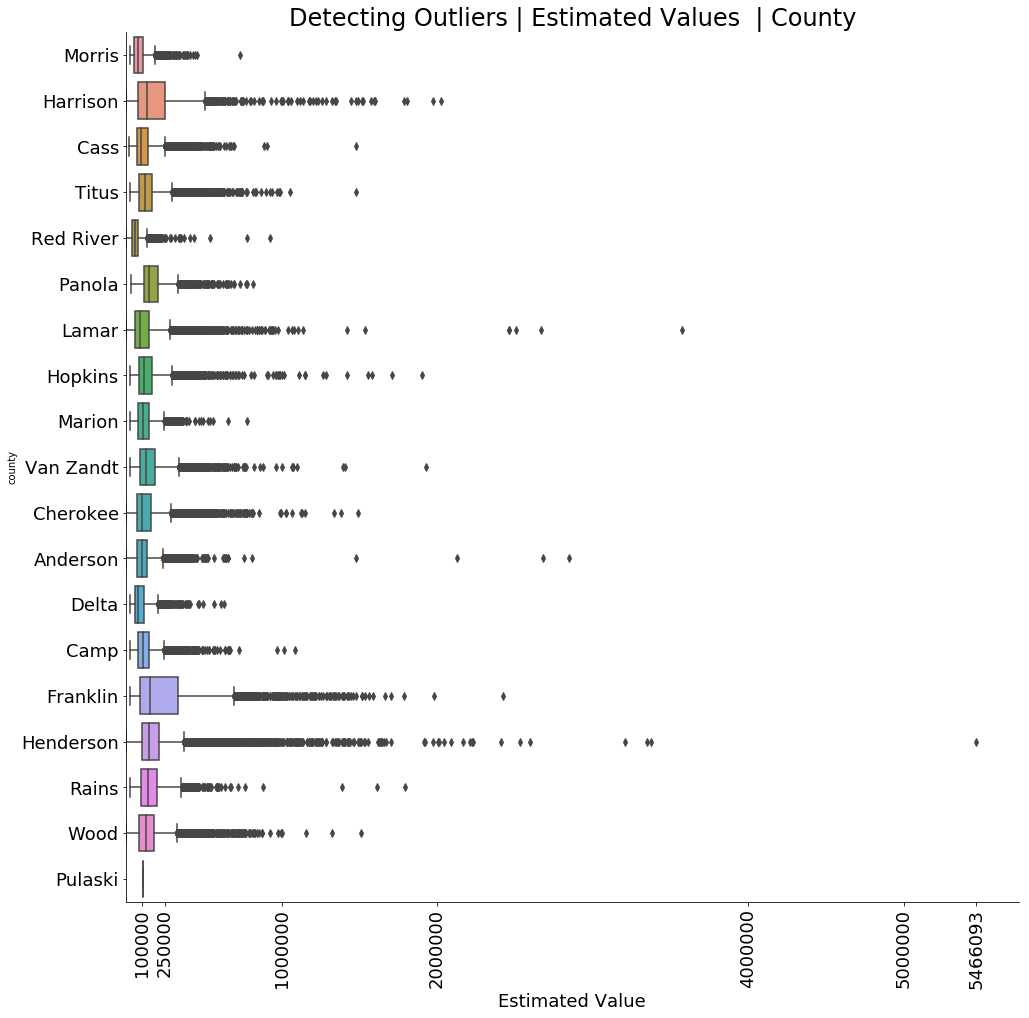

In [70]:
fig, ax = plt.subplots(figsize=[16, 16])
sns.boxplot(
    data=data,
    y=data.county,
    x=data.estimatedValue
)
ax.set_title('Detecting Outliers | Estimated Values  | County', fontsize = 24)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim(0,)
plt.xticks(( 100000, 250000,  1000000, 2000000, 4000000, 5000000, max_value), fontsize = 18, rotation = 90)
plt.yticks(fontsize = 18)
plt.xlabel('Estimated Value', fontsize = 18)

### 2.2 Looking into Henderson County

In [31]:
# creating henderson county mask
henderson = data.county == 'Henderson'
hdata = data[henderson]

In [32]:
len(hdata), len(data), (len(hdata)/len(data))*100

(53920, 234216, 23.021484441711923)

Text(0.5, 1.0, 'Estimated Value Distribution \n Henderson County')

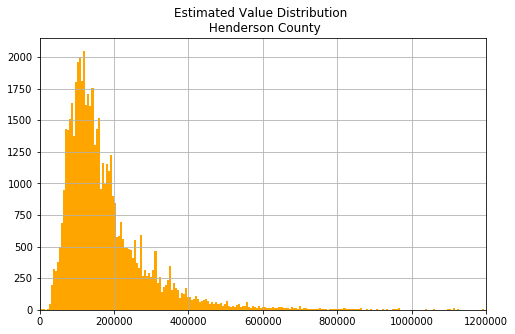

In [73]:
hdata.estimatedValue.hist(bins = 1000, figsize = (8, 5), color = 'orange')
plt.xlim(0,1200000)
plt.title('Estimated Value Distribution \n Henderson County')

In [23]:
hdata[['rooms', 'bedrooms', 'bathrooms', 'lastSaleAmount','priorSaleAmount']].describe()

,rooms,bedrooms,bathrooms,lastSaleAmount,priorSaleAmount
count,53920.0,53920.0,53920.000000,12058.000000,2727.000000
mean,0.0,0.0,1.188807,3804.653840,12384.719839
std,0.0,0.0,2.179751,25175.840323,39009.188896
min,0.0,0.0,0.000000,0.000000,0.000000
25%,0.0,0.0,0.000000,0.000000,0.000000
50%,0.0,0.0,0.000000,0.000000,0.000000
75%,0.0,0.0,1.500000,0.000000,0.000000
max,0.0,0.0,13.000000,925000.000000,524885.000000


#### Looks like we have zeros entered instead of NaNs

In [24]:
hdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53920 entries, 65 to 233873
Data columns (total 24 columns):
id                     53920 non-null int64
address                53463 non-null object
city                   52899 non-null object
county                 53920 non-null object
countyFIPS             53920 non-null int64
state                  53920 non-null object
zipcode                52895 non-null float64
latitude               33753 non-null float64
longitude              33753 non-null float64
bedrooms               53920 non-null int64
bathrooms              53920 non-null float64
rooms                  53920 non-null int64
squareFootage          28233 non-null float64
lotSize                14604 non-null float64
yearBuilt              23705 non-null float64
taxYear                53920 non-null int64
taxAssessedValue       53842 non-null float64
taxMarketValue         53842 non-null float64
taxImprovementValue    34603 non-null float64
lastSaleDate           49260 

Text(0.5, 1.0, 'Null Values(Blue). Henderson County')

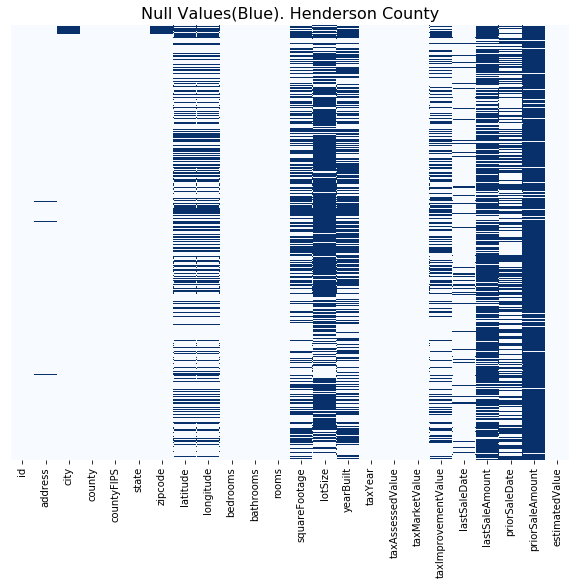

In [37]:
plt.figure(figsize = (10, 8))
sns.heatmap(hdata.isnull(), yticklabels = False, cbar = False, cmap = 'Blues')
plt.title('Null Values(Blue). Henderson County', fontsize = 16)

In [59]:
(7409/len(hdata))*100 

13.74072700296736

In [38]:
hdata.columns

Index(['id', 'address', 'city', 'county', 'countyFIPS', 'state', 'zipcode',
       'latitude', 'longitude', 'bedrooms', 'bathrooms', 'rooms',
       'squareFootage', 'lotSize', 'yearBuilt', 'taxYear', 'taxAssessedValue',
       'taxMarketValue', 'taxImprovementValue', 'lastSaleDate',
       'lastSaleAmount', 'priorSaleDate', 'priorSaleAmount', 'estimatedValue'],
      dtype='object')

In [39]:
miss_taximprov = sum(hdata.taxImprovementValue.isnull())/len(hdata)*100
miss_sq = sum(hdata.squareFootage.isnull())/len(hdata)*100
miss_lotsize = sum(hdata.lotSize.isnull())/len(hdata)*100
miss_yearb = sum(hdata.yearBuilt.isnull())/len(hdata)*100

print('Missing Values percentage for taxImprovementValue is: {}%'.format(round(miss_taximprov, 2)))
print('Missing Values percentage for Square Footage is: {}%'.format(round(miss_sq, 2)))
print('Missing Values percentage for Lot Size is: {}%'.format(round(miss_lotsize, 2)))
print('Missing Values percentage for Year Built is: {}%'.format(round(miss_yearb, 2)))

Missing Values percentage for taxImprovementValue is: 35.83%
Missing Values percentage for Square Footage is: 47.64%
Missing Values percentage for Lot Size is: 72.92%
Missing Values percentage for Year Built is: 56.04%


In [40]:
def count_missed_percent(data, column):
    missed_column = sum(data[column].isnull())/len(data)*100
    print('Missing Values percentage for {} is: {}%'.format(column, round(missed_column, 2)))

In [41]:
count_missed_percent(hdata, 'priorSaleAmount')

Missing Values percentage for priorSaleAmount is: 94.94%


Text(0.5, 1.0, 'Correlation Matrix. Henderson County')

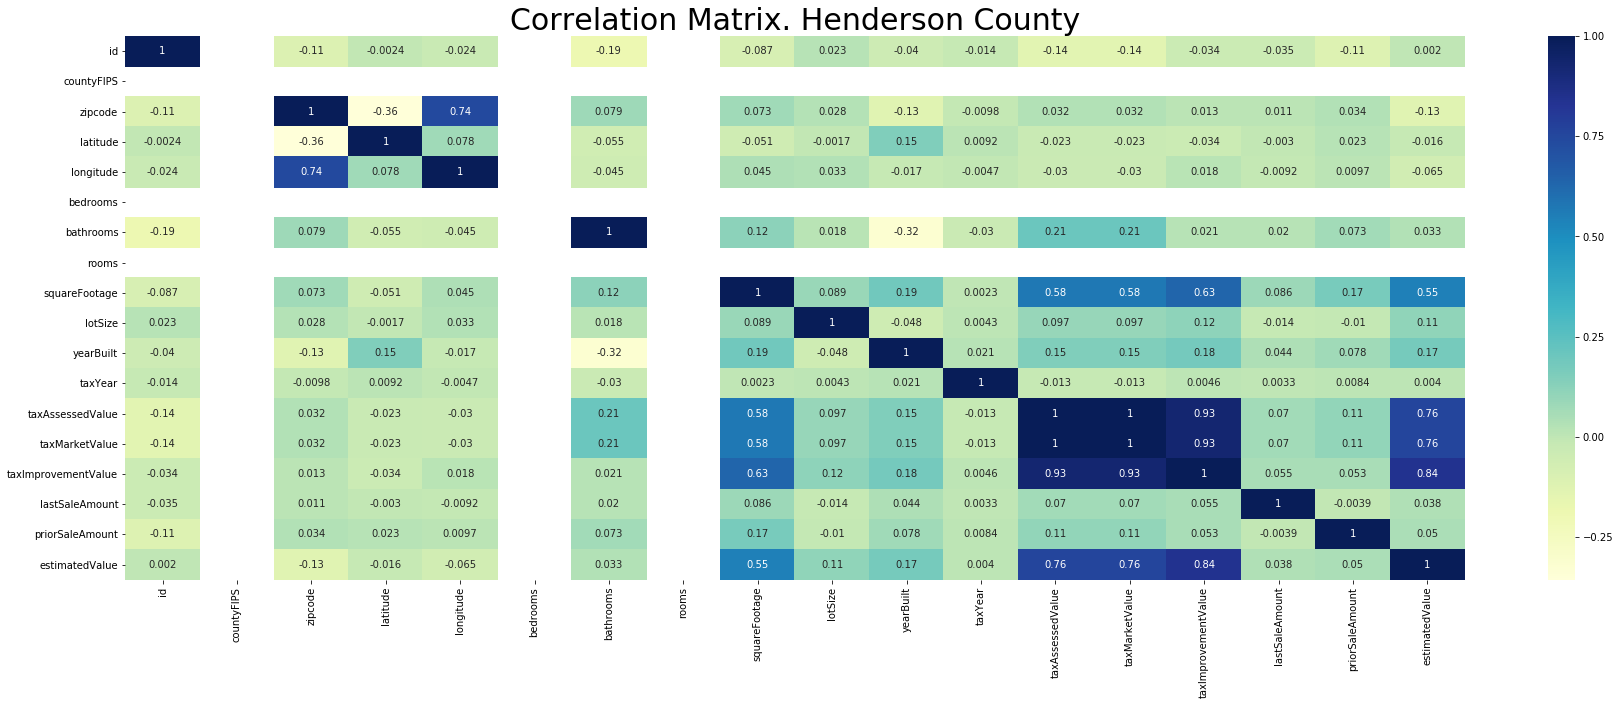

In [42]:
# looking at the correlation matrix for features in Henderson county
plt.figure(figsize = (30, 10))
sns.heatmap(hdata.corr(), annot = True, cmap="YlGnBu")
plt.title('Correlation Matrix. Henderson County', fontsize = 30)


/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


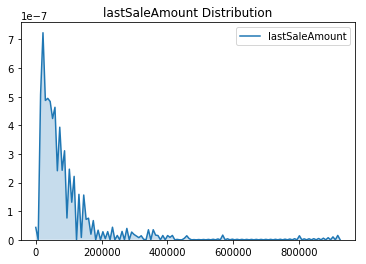

In [43]:
plt.title('lastSaleAmount Distribution', fontsize = 12)

ax = sns.kdeplot(hdata.lastSaleAmount,
                  shade=True,shade_lowest=False)


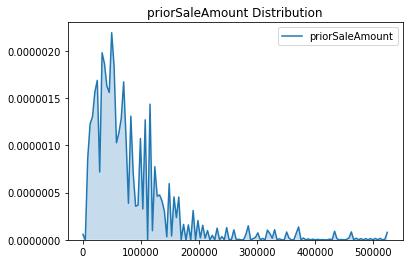

In [44]:
plt.title('priorSaleAmount Distribution', fontsize = 12)

ax = sns.kdeplot(hdata.priorSaleAmount,
                  shade=True,shade_lowest=False)



In [45]:
a = round(((sum_data[henderson_mask].nObservations.values[0]/len(data[henderson])) *100 ), 2)
print('{}% of total observations used for training the model in Henderson County '.format( a))

13.74% of total observations used for training the model in Henderson County 


### Hypothesis is that zeros were entered instead of nans

In [46]:
hdata.columns

Index(['id', 'address', 'city', 'county', 'countyFIPS', 'state', 'zipcode',
       'latitude', 'longitude', 'bedrooms', 'bathrooms', 'rooms',
       'squareFootage', 'lotSize', 'yearBuilt', 'taxYear', 'taxAssessedValue',
       'taxMarketValue', 'taxImprovementValue', 'lastSaleDate',
       'lastSaleAmount', 'priorSaleDate', 'priorSaleAmount', 'estimatedValue'],
      dtype='object')


## Detecting Outliers
    
 


In [50]:
# most expensive house:
max_value = hdata.estimatedValue.max()
hdata[hdata.estimatedValue == max_value].describe()

,id,countyFIPS,zipcode,latitude,longitude,bedrooms,bathrooms,rooms,squareFootage,lotSize,yearBuilt,taxYear,taxAssessedValue,taxMarketValue,taxImprovementValue,lastSaleAmount,priorSaleAmount,estimatedValue
count,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
mean,231279623.0,48213.0,NaN,NaN,NaN,0.0,0.0,0.0,1134.0,2097414.0,2001.0,2018.0,5983940.0,5983940.0,2899490.0,NaN,NaN,5466093.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,231279623.0,48213.0,NaN,NaN,NaN,0.0,0.0,0.0,1134.0,2097414.0,2001.0,2018.0,5983940.0,5983940.0,2899490.0,NaN,NaN,5466093.0
25%,231279623.0,48213.0,NaN,NaN,NaN,0.0,0.0,0.0,1134.0,2097414.0,2001.0,2018.0,5983940.0,5983940.0,2899490.0,NaN,NaN,5466093.0
50%,231279623.0,48213.0,NaN,NaN,NaN,0.0,0.0,0.0,1134.0,2097414.0,2001.0,2018.0,5983940.0,5983940.0,2899490.0,NaN,NaN,5466093.0
75%,231279623.0,48213.0,NaN,NaN,NaN,0.0,0.0,0.0,1134.0,2097414.0,2001.0,2018.0,5983940.0,5983940.0,2899490.0,NaN,NaN,5466093.0
max,231279623.0,48213.0,NaN,NaN,NaN,0.0,0.0,0.0,1134.0,2097414.0,2001.0,2018.0,5983940.0,5983940.0,2899490.0,NaN,NaN,5466093.0


In [51]:
max_value

5466093

In [60]:
# std method
mean_y = hdata.estimatedValue.mean()
median_y = hdata.estimatedValue.median()
std_y = hdata.estimatedValue.std()
outlier_std_method = mean_y +3*std_y
max_value = hdata.estimatedValue.max()
max_value

5466093

In [61]:
# iqr method
q75, q25 = np.percentile(hdata.estimatedValue.dropna(), [75 ,25])
iqr = q75 - q25
 
min = q25 - (iqr*1.5)
outlier_iqr_method = q75 + (iqr*1.5)
outlier_iqr_method

374000.0

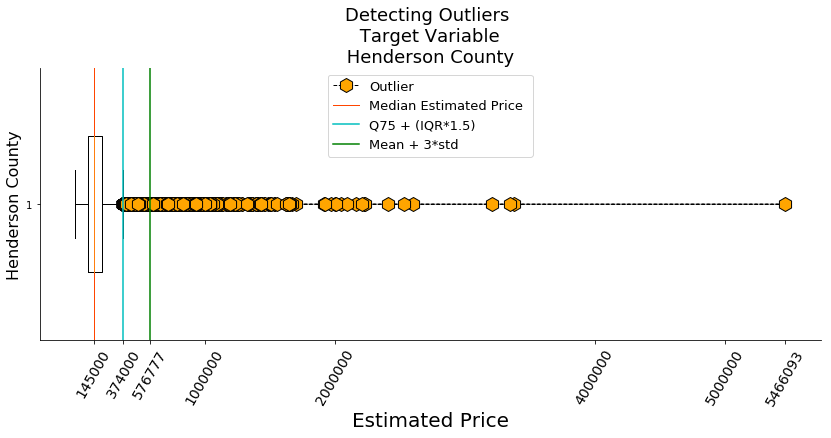

In [62]:
fig, ax1 = plt.subplots(figsize=[14, 5])

ax1.set_title('Boxplot, Estimated Values | County')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)


flierprops = dict(marker='h', markerfacecolor='orange', markersize=14, 
                  linestyle='--', label = 'Outlier')
ax1.set_title('Detecting Outliers \n Target Variable \n Henderson County ', fontsize = 18)
ax1.boxplot(hdata.estimatedValue, vert=False, flierprops=flierprops, meanline = True, widths=(1))
ax1.axvline(x = median_y, c = 'orangered', label = 'Median Estimated Price ', linewidth = 1.0)
ax1.axvline(x = outlier_iqr_method , c = 'c', label = 'Q75 + (IQR*1.5)')
ax1.axvline(x = outlier_std_method , c = 'green', label = 'Mean + 3*std')
plt.ylim(0, 2)
plt.legend(loc='upper center',  fontsize = 13)
plt.xticks(( median_y, outlier_iqr_method, outlier_std_method, 1000000, 2000000, 4000000, 5000000, max_value), fontsize = 14, rotation = 60)
plt.ylabel('Henderson County', fontsize = 16)
plt.xlabel('Estimated Price', fontsize = 20)


plt.show()




### Looking at the cities for Henderson County


In [49]:
hdata.columns

Index(['id', 'address', 'city', 'county', 'countyFIPS', 'state', 'zipcode',
       'latitude', 'longitude', 'bedrooms', 'bathrooms', 'rooms',
       'squareFootage', 'lotSize', 'yearBuilt', 'taxYear', 'taxAssessedValue',
       'taxMarketValue', 'taxImprovementValue', 'lastSaleDate',
       'lastSaleAmount', 'priorSaleDate', 'priorSaleAmount', 'estimatedValue'],
      dtype='object')

In [1]:
plt.title('AVG Estimated Cost \n Henderson County Cities', fontsize = 18)
plt.grid(c = 'lemonchiffon', linestyle = '--')

ax = hdata.groupby('city').max()['estimatedValue'].sort_index().plot.bar(
    figsize = (14,6),
    fontsize = 14, edgecolor='dimgrey')

plt.ylabel('$ AVG Estimated Cost', fontsize = 14)

NameError: name 'plt' is not defined

### Checking on VIF Factor. Fitting data into Linear Regression Model

In [51]:

hdata.dropna()
hdata = hdata._get_numeric_data()
hdata = hdata[['bathrooms','squareFootage', 'lotSize', 'yearBuilt',
       'taxYear', 'taxAssessedValue', 'taxMarketValue', 'taxImprovementValue', 'estimatedValue']].dropna()

features = hdata.drop(['estimatedValue'], 1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c36925fd0>,
      dtype=object)

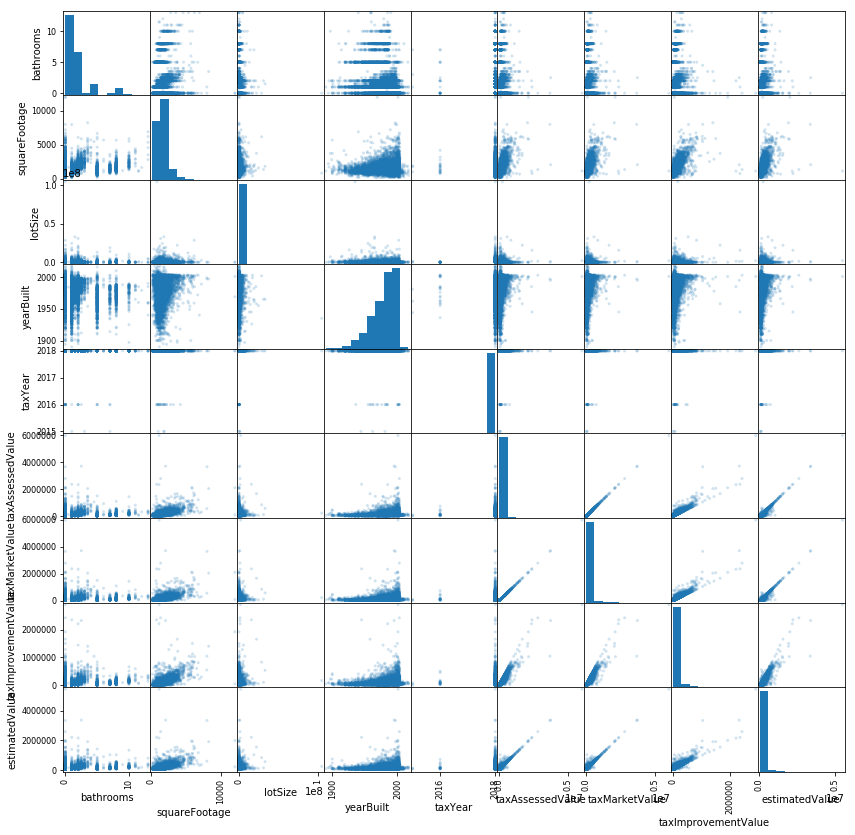

In [60]:

pd.scatter_matrix(hdata, alpha=0.2, figsize = (14,14))

In [52]:
X = hdata.drop(['estimatedValue'], 1).values

y = hdata['estimatedValue']
X.shape, y.shape

((8119, 8), (8119,))

In [53]:
model = sm.OLS(y, X) 
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         estimatedValue   R-squared (uncentered):                   0.974
Model:                            OLS   Adj. R-squared (uncentered):              0.974
Method:                 Least Squares   F-statistic:                          4.375e+04
Date:                Sun, 12 May 2019   Prob (F-statistic):                        0.00
Time:                        16:51:40   Log-Likelihood:                         -97592.
No. Observations:                8119   AIC:                                  1.952e+05
Df Residuals:                    8112   BIC:                                  1.952e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            69.4190    200.769      0.346      0.730    -324.141     462.979
x2             6.1167      0.738      8.289      0.000       4.670       7.563
x3             0.0030      0.000     11.892      0.000       0.002       0.003
x4           116.3051     24.963      4.659      0.000      67.372     165.238
x5           -83.8297     24.434     -3.431      0.001    -131.726     -35.933
x6             0.4458      0.003    133.665      0.000       0.439       0.452
x7             0.4458      0.003    133.665      0.000       0.439       0.452
x8            -0.0198      0.010     -1.988      0.047      -0.039      -0.000
==============================================================================
Omnibus:                     8544.017   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1468910.656
Skew:                           4.926   Prob(JB):                         0.00
Kurtosis:                      68.154   Cond. No.                     2.22e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.84e-19. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [54]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif["features"] = features.columns

/anaconda3/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [55]:
vif.round(1)

,VIF Factor,features
0,1.700000e+00,bathrooms
1,8.800000e+00,squareFootage
2,1.100000e+00,lotSize
3,1.225670e+04,yearBuilt
4,1.221190e+04,taxYear
5,inf,taxAssessedValue
6,inf,taxMarketValue
7,1.370000e+01,taxImprovementValue


# Data Analyst Project Overview
**Project Goals**
Your goal is to investigate the dataset, provide a high level overview of what you see, describe any data issues, and provide your interpretation of what might be underlying the poor performance of the model in Henderson County.

First, we would like a high-level overview: your assessment of the data quality, your hypothesis on why Henderson County's model performance is worse than other counties, and any other interesting pieces of information you found that might be relevant to us.

Next, we'd like your insight: Having spent some time with the data, where would you take your analysis next, given more time? What additional data would you like to collect? (Be creative, pretend anything is possible!) What questions do you still have that you weren't able to answer?

The final deliverable will be a slide deck for presentation, along with any code you’ve used to generate your analysis. 

## Report. Poor Performance of the Model in Henderson County

**Problem**
_Property valuation model is performing significantly lower **0.49 Abs Error** in Henderson County_

Based on high level overview of the data sets provided I conclude that Henderson County Model is an underfit model that has low variance and high bias due to the sparcity of the training data in addition to the presence of extreme outliers and multicollinearity of independent variables.
### **Data Issues and Recommendations for Handling them** 

#### **1. Data Accuracy** 

1.1.1. **Problem: Incorrect data**. Zeros are entered instead of NaN.   </br>
   * _rooms, bedrooms, bathrooms_ (all zeros, show corr mat, value counts ),
   * _lastSaleAmount, priorSaleAmount_
   
1.1.2. **Recommendation**  </br>
   * Replace zero values with NaN. Deploy the model w/ adjustment. Remove features with incorrect values. 
   * Collect data on rooms, bathrooms, bedrooms as they should be a solid predictor. Normally a property with more rooms/bathrooms/bedrooms has stronger capability to increase the price.
   
1.2.1 **Problem Data Completeness**. </br>
   * Sparse data in general. Only **13.74%** of the all data was used training the model(Henderson County) due to many null values.</br>
1.2.2 **Recommendation**
   * Collect more data for better predicive power of the model.   
   
#### **2. Outliers**  
2.1.1 **Problem.** Observed outliers in Henderson county. </br>
2.1.2 **Recommendation** </br>
   * Treat outliers (remove, log transform, cap data, assign new values) </br>
   * Try models that are robust to outliers (i.e. regression tree model)) </br>
   * Remove the most Extreme Outliers (i.e. Huge outlier for Henderson County) and rerun the model to see if the score imporves. 
   * Deploy an additional model for outlier houses (identify if the houses are luxury/ not as an additional feature)  
   
#### **3. Multicollinearity of predictors** </br>
   * _'taxAssessedValue','taxMarketValue', 'taxImprovementValue'_ </br>
   3.1.1 **Problem.** Multicollinearity can yield to predictions that are wildly varying and possibly numerically unstable.</br>
   3.1.2 **Recommendation**</br>
   * Perform feature eng for the tax related features due to multicollinearity. For example, we can use the AVG between these 3 features aggregating all three features into one. </br>
   
#### **4. What additional data would you like to collect?**</br>
Some useful feature may include: 
* Luxury (binary yes/no), commercial/residential
* Location-specific outcomes: number of permits issued to build swimming pools (restaurants, coffee shops, etc), * change in number of coffee shops within a one-mile
* building energy consumption relative to other structures in the same zip code
* renewal energy service
* in-office mobility, based on frequency of elevator movement
* number of Yelp reviews for nearby businesses

#### 5. What questions do you still have that you weren't able to answer?

* Look into more details on why other counties perform better on the sparse data and determine if there are any other underlying factors. 
* Is it possible that different models were deployed for different counties so that outliers are treated differently for other counties/or they were removed
* What was the outlier treatment for the model? 
* How was the problem of multicollinearity handled in building the models? 
* Was there a practice to enter zero values for nan during data entry? If yes, perhaps we should address it.    